# BDSA 603 - Big Data Analytics
# Practice 2 - Analytics on UK Smart Meter Data

* ### Supervised By: Dr. Hesham Al-Ammal
* ### Coded By: Ahmed Khedr
* ### UOB ID: 20113798

## Introduction
Energy plays an important role in every aspect of today’s world. 
With the ever-increasing demand for energy, comes the importance of understanding how it is being consumed to allow governments to reduce carbon emissions, efficiently use and conserve energy, and plan for reliable energy sources.
***
## Research Problem
This research & implemented analysis aims to:
1. Explore relationship between weather condition and energy consumption
2. Explore relationship between UK holidays and energy consumption
3. Explore (& visualize) the relationship between ACORN household categorization and energy consumption over a year
***
## Research Scope
* The United Kingdom
* Energy readings from November 2011 until February 2014 (subject to data cleansing)
* Weather conditions that will be considered in this research will be **temperature only**
***
## Data Sources
* UK Power Networks (https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)
* Smart Meters in London (https://www.kaggle.com/jeanmidev/smart-meters-in-london)
***
***

# Data Collection & Preparation
In this section, we will:
* Clean up the datasets
* Combine and prepare the dataset
* Investigate inconsistency and missing values

In [1]:
%%time
import os # Operating System
import datetime # DateTime
import numpy as np # NumPy
import pandas as pd # Pandas
import seaborn as sns # Seaborn
import matplotlib.pyplot as plt # Mat-Plot Lib

Wall time: 3.87 s


# Global Variables 
Including Research Scoping

In [2]:
# Define Study Time Frame (Years) - as defined by research
StudyTimeFrame_StartYear = 2011
StudyTimeFrame_EndYear = 2014

# Datetime Format
datetimeFormat = '%Y-%m-%d'

# Dataset directory
Dataset_Directory = 'dataset/'
CleanedDataset_Directory = 'dataset_clean/'

# Load and Clean Up Simple Datasets

### Load & Clean UK Holidays

In [3]:
%%time
df_UKHolidays = pd.read_csv(f"{Dataset_Directory}uk_bank_holidays.csv")
# df_UKHolidays.info()

# Rename columns to be read-able
df_UKHolidays.columns = ['Date', 'Name']

# Convert 'Date' to DateTime data type
df_UKHolidays['Date'] = pd.to_datetime(df_UKHolidays['Date'])

# Create Date Only Attribute
df_UKHolidays['DateOnly'] = df_UKHolidays['Date'].dt.strftime(datetimeFormat)

# Drop duplicates by Date
df_UKHolidays = df_UKHolidays.drop_duplicates(subset=['Date'])

# Remove null data
df_UKHolidays.dropna()

# Sort by Date
df_UKHolidays = df_UKHolidays.sort_values(by='Date')

# Ensure no null values exist in all columns 
#assert df_UKHolidays.isnull().sum().sum() == 0

Wall time: 28.9 ms


Wall time: 124 ms


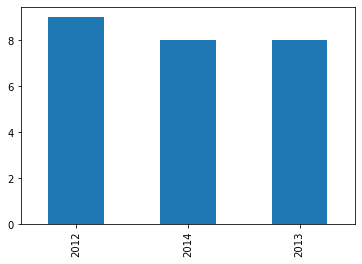

In [4]:
%%time
Count_UKHolidays_ByYear = df_UKHolidays["Date"].dt.year.value_counts()
Count_UKHolidays_ByYear.plot.bar() # We can see that we do not have holidays for 2011

# Update Study Time Frame
StudyTimeFrame_StartYear = min(df_UKHolidays["Date"].dt.year)
StudyTimeFrame_EndYear = max(df_UKHolidays["Date"].dt.year)

### Load & Clean ACORN Categories

In [5]:
%%time
df_ACORN = pd.read_csv(f"{Dataset_Directory}acorn_categories.csv")
#df_ACORN.info()

# Rename columns to be read-able
df_ACORN.columns = ['Code', 'Name', 'Group_Name', 'Color']

# Select only relevent columns
df_ACORN = df_ACORN[['Code', 'Name', 'Color']]

# Drop duplicates
df_ACORN = df_ACORN.drop_duplicates()

# Remove null data
df_ACORN.dropna()

# Ensure no null values exist in all columns 
assert df_ACORN.isnull().sum().sum() == 0

Wall time: 18.6 ms


### Load & Clean Households

In [6]:
%%time
df_Households = pd.read_csv(f"{Dataset_Directory}informations_households.csv")
#df_Households.info()

# Select only relevent columns
df_Households = df_Households[['LCLid', 'Acorn']]

# Rename columns to be read-able
df_Households.columns = ['ID', 'ACORN_Category']

# Apply striping of "ACORN-" from category code
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].apply(lambda x: x.upper().replace('ACORN-','').strip())

df_Households_invalid = pd.DataFrame() 
# Remove Empty ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[df_Households['ACORN_Category']==""])
df_Households = df_Households[df_Households['ACORN_Category']!=""]

# Remove invalid ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[~df_Households['ACORN_Category'].isin(df_ACORN['Code'])])
df_Households = df_Households[df_Households['ACORN_Category'].isin(df_ACORN['Code'])]

# Create new attribute for ACORN code
df_Households['ACORN_Code'] = df_Households['ACORN_Category']
# Replace ACORN category code with category name (to group data by ACORN categery rather ACORN group)
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].map(df_ACORN.set_index('Code')['Name'])

# Drop duplicates by ID
df_Households = df_Households.drop_duplicates(subset=['ID'])

# Remove null data
df_Households.dropna()

# Ensure no null values exist in all columns 
assert df_Households.isnull().sum().sum() == 0

Wall time: 48.8 ms


Wall time: 39.3 ms


<AxesSubplot:>

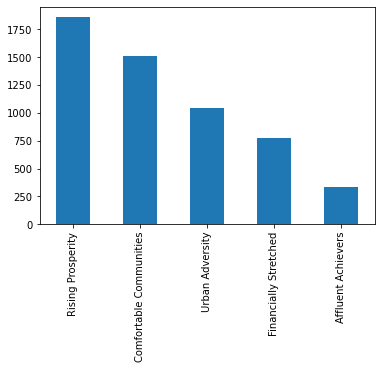

In [7]:
%%time
Count_Households_ByACORNCategory = df_Households["ACORN_Category"].value_counts()
Count_Households_ByACORNCategory.plot.bar() # Visualization to see distribution of houses on ACORN categories

### Load & Clean Weather Data

In [8]:
%%time
df_Weather = pd.read_csv(f"{Dataset_Directory}weather_daily_darksky.csv")
#df_Weather.info()

# Select only relevent columns
df_Weather = df_Weather[['time', 'temperatureMax', 'temperatureMin']]

# Rename columns to be read-able
df_Weather.columns = ['Date', 'Temp_Max', 'Temp_Min']

# Convert 'Date' to DateTime data type
df_Weather['Date'] = pd.to_datetime(df_Weather['Date'])

# Drop duplicates by Date
df_Weather = df_Weather.drop_duplicates(subset=['Date'])

# Create Date Only Attribute
df_Weather['DateOnly'] = df_Weather['Date'].dt.strftime(datetimeFormat)

# Remove null data
df_Weather.dropna()

# Calculate the Average Temperature for each day
df_Weather['Temp_Avg'] = np.mean([df_Weather['Temp_Max'], df_Weather['Temp_Min']], axis=0)

# Sort by Date
df_Weather = df_Weather.sort_values(by='Date')

# Ensure no null values exist in all columns 
assert df_Weather.isnull().sum().sum() == 0

Wall time: 142 ms


Wall time: 73 ms


<AxesSubplot:>

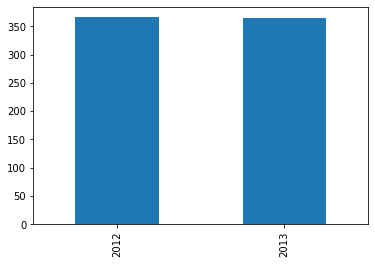

In [9]:
%%time
# Verify Weather Data Availability
Count_WeatherData_ByYear = df_Weather["Date"].dt.year.value_counts()
Count_WeatherData_ByYear.plot.bar() # We can see that we do not have enough data for 2011 and 2014

# Update Study Time Frame (years that have full daily weather records)
StudyTimeFrame_StartYear = min(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)
StudyTimeFrame_EndYear = max(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)

# Remove excluded data
df_Weather = df_Weather[(StudyTimeFrame_StartYear <= df_Weather['Date'].dt.year) &
                        (df_Weather['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Verify Weather Data Availability
Count_WeatherData_ByYear = df_Weather["Date"].dt.year.value_counts()
Count_WeatherData_ByYear.plot.bar() # We can see that we do not have enough data for 2011 and 2014

Wall time: 101 ms


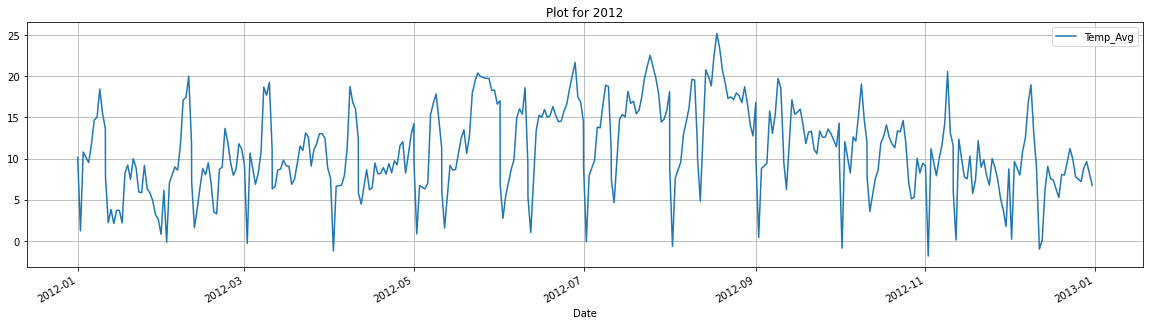

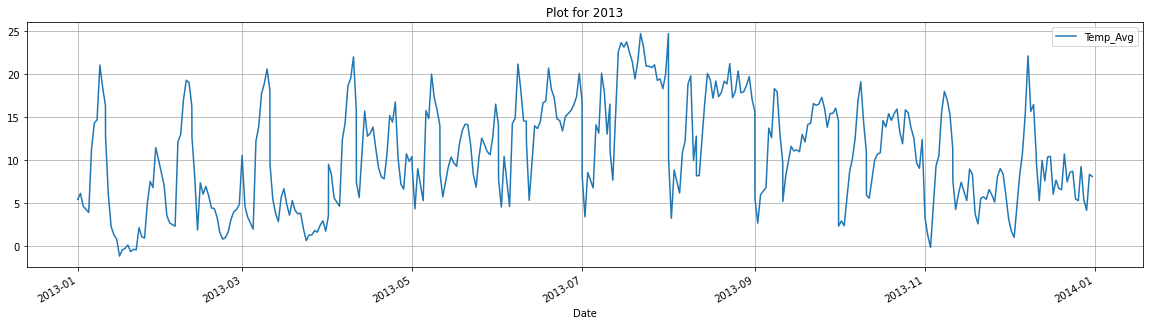

In [10]:
%%time
# Visualize Weather Data for each Year (Daily Visualization)
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):
    df_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)    
    df_SingleGroupedYear.plot(x='Date', y='Temp_Avg', title='Plot for '+ str(SingleGroupedYear),
                              figsize=(20,5), grid=True, legend = True)

Wall time: 48.8 ms


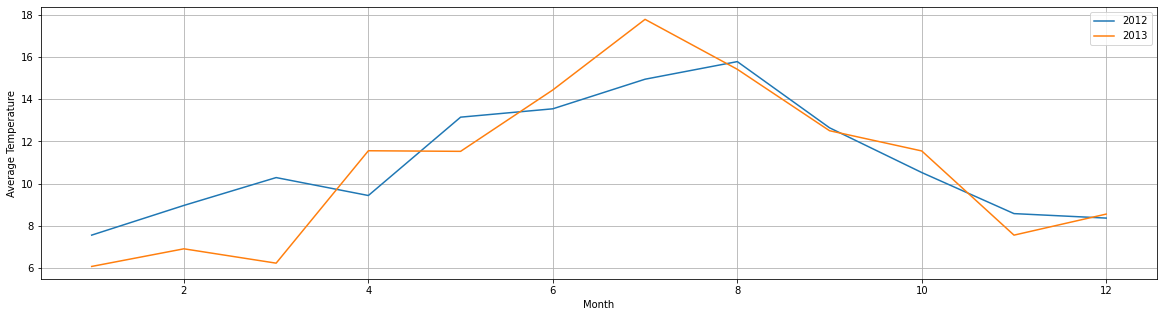

In [11]:
%%time
# Visualize Weather Data for each Year (Monthly Visualization)
plt.figure(figsize=(20,5)) 
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):    
    df_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)    
    df_SingleGroupedYear_ByMonth = df_SingleGroupedYear.groupby(df_SingleGroupedYear['Date'].dt.month)['Temp_Avg'].mean()
    plt.plot(df_SingleGroupedYear_ByMonth)
    plt.xlabel('Month')
    plt.ylabel('Average Temperature')
    plt.legend(dict(list(df_Weather_GroupedByYear)))
    plt.grid(True)

---
# Use Big Data
## We have two main large datasets
1. UK Power Networks (168 files - containing 30 minute interval energy consumption readings)
2. Daily Energy Consumptions Readings (112 files - containing the daily aggregated energy consumptions for all households)

In [12]:
# Import Map Reduce and Dask
from MR_SumEC_ByHousehold_ByDate import MR_SumEC_ByHousehold_ByDate # MR - Task 1
import dask # Dask
from dask.distributed import Client # Dask Distributed
import dask.dataframe as ddf # Dask Dataframe Implementation

In [13]:
%%time
# Create Dask Client
daskClient = Client(threads_per_worker=4,n_workers=2,memory_limit='2GB')
daskClient

Wall time: 1.82 s


Client Scheduler: tcp://127.0.0.1:50148 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 4.00 GB


---
# Task 0: Explore which method is best to conduct analysis

### Methods:
1.	Using MapReduce (through MRJob package available through Python)
2.	Using Dask (package available through Python)
3.	Using Dask to execute parallel MapReduce jobs (a blend of the first two methods) 

### To determine which method works best for this task, we will test on two files and compare performance.

##### This below function exposes and allows us to execute the  Map Reduce Job

In [14]:
def Execute_Task1_MRJob(Dataset_Path, Dataset_OutputPath):
    finalargs = Dataset_Path + ["--fYS", str(StudyTimeFrame_StartYear),"--fYE", str(StudyTimeFrame_EndYear)]    
    MRJob_1 = MR_SumEC_ByHousehold_ByDate(args = finalargs)
    with MRJob_1.make_runner() as runner_temp:
        runner_temp.run()
        df_mrjob_response = pd.DataFrame(MRJob_1.parse_output(runner_temp.cat_output()))
        # Reset index to push multi-key as columns
        # df_mrjob_response.reset_index(inplace=True)
        df_mrjob_response.to_csv(Dataset_OutputPath, mode='w', header=False, index=False)
    return Dataset_OutputPath

##### This below function executes the Map Reduce Job Directly by providing the list of Files (no Dask involved)

In [15]:
def Process_Task1_ByDirectMR():
    UKPowerNetworks_DatasetDir = r'dataset/testTask1Input/'
    UKPowerNetworks_OutputDir = r'dataset/testTask1Output/'
    UKPowerNetworks_FileCollection = []
    for ukPowerNetworksFile in os.listdir(UKPowerNetworks_DatasetDir):
        dataset_fullPath = os.path.join(UKPowerNetworks_DatasetDir, ukPowerNetworksFile)
        UKPowerNetworks_FileCollection.append(f'./{dataset_fullPath}')
    dataset_outputPath = os.path.join(UKPowerNetworks_OutputDir, 'v_directmr.csv')    
    return Execute_Task1_MRJob(UKPowerNetworks_FileCollection, dataset_outputPath)

##### This below function executes the Map Reduce Job by leverage parallelization from Dask

In [16]:
def Process_Task1_ByDask():
    UKPowerNetworks_DatasetDir = r'dataset/testTask1Input/'
    UKPowerNetworks_OutputDir = r'dataset/testTask1Output/'
    UKPowerNetworks_CompletedFiles = []
    for ukPowerNetworksFile in os.listdir(UKPowerNetworks_DatasetDir):
        dataset_fullPath = os.path.join(UKPowerNetworks_DatasetDir, ukPowerNetworksFile)
        dataset_outputPath = os.path.join(UKPowerNetworks_OutputDir, ukPowerNetworksFile.replace('Power-Networks-LCL-June2015(withAcornGps)',''))
        locally_completedfile = dask.delayed(Execute_Task1_MRJob)([f'./{dataset_fullPath}'], f'./{dataset_outputPath}')
        UKPowerNetworks_CompletedFiles.append(locally_completedfile)
    return UKPowerNetworks_CompletedFiles

---
---
### Test 1.1 - Testing Task 1 using Direct MR Job (no Dask involved)
The test was conducted using only 2 files for simplification and since it is directly implemented on MRJob, the output is combined into one file (v_directmr.csv)
#### The test took approx. 4 min and 50 seconds (Resulting in 36,543 records)

In [18]:
%%time
print(Process_Task1_ByDirectMR())

No configs specified for inline runner


dataset/testTask1Output/v_directmr.csv
Wall time: 4min 52s


In [19]:
df_test1_1 = ddf.read_csv('dataset/testTask1Output/v_directmr.csv', names=["Key", "Value"], header=None)
df_test1_1.count().compute()

Key      36543
Value    36543
dtype: int64

---
---
### Test 1.2 - Testing Task 1 using Direct MR Job and leveraging parallelization from Dask
The test was conducted using only 2 files for simplification and since each MR job was submitted individually, each will have its own output file.
#### The test took approx. 3 min (Resulting in 36,543 records)

In [20]:
%%time
UKPowerNetworks_CompletedFiles = []
UKPowerNetworks_CompletedFiles = dask.compute(Process_Task1_ByDask())
UKPowerNetworks_CompletedFiles

Wall time: 3min 1s


(['./dataset/testTask1Output/v2_1.csv',
  './dataset/testTask1Output/v2_168.csv'],)

In [21]:
df_test1_2 = ddf.read_csv('dataset/testTask1Output/v2_*.csv', names=["Key", "Value"], header=None)
df_test1_2.count().compute()

Key      36543
Value    36543
dtype: int64

---
---
### Test 1.3 - Testing Task 1 using Dask only
The test was conducted using only 2 files for simplification and since we are using Dask, we can combine both files into one output file (v_dask.csv).
However, since this will not leverage the code written in the MRJob, we will implement the same logic here.
#### The test took approx. 20 seconds (Results in 36,543 records)

In [22]:
%%time
# Load SubSet of Data
df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/testTask1Input/*.csv',
                                          names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                          header=0)

# Convert 'Date' to DateTime data type
df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

# Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
    ## Declare midnight
midnight = datetime.time(0,0)
    ## Extract midnight records
df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight].compute()
    ## Remove midnight records from dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
    ## Shift midnight to -1 minute
df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
    ## Re-merge updated records with dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

# Filter out excluded dates (Study Time Frame)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                        &
                                                        (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Convert EC readings to numeric (otherwise NaN)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

# Filter out invalid energy consumption readings
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

# Create Date Only attribute to allow for group-by function
df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)
# Group By (Household ID and Date Only)
df_UKPowerNetworks_ByHouse_ByDate = pd.DataFrame(df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).EC.sum().compute())
# Reset index to push multi-key as columns
df_UKPowerNetworks_ByHouse_ByDate.reset_index(inplace=True)
# Re-assign as Dask Dataframe
df_UKPowerNetworks_ByHouse_ByDate = ddf.from_pandas(df_UKPowerNetworks_ByHouse_ByDate, npartitions=4)

df_UKPowerNetworks_ByHouse_ByDate.to_csv('dataset/testTask1Output/v_dask.csv', index=False, single_file=True)
df_UKPowerNetworks_ByHouse_ByDate.count().compute()

Wall time: 22.7 s


HouseID     36543
DateOnly    36543
EC          36543
dtype: int64

In [23]:
# Final Verification of ensure all previous tests yield the same results

# RegEx to split Key into HouseID and DateOnly from MR Job
df_test1_1 = df_test1_1.assign(HouseID = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[1])
df_test1_1 = df_test1_1.assign(DateOnly = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[3])

# RegEx to split Key into HouseID and DateOnly from MR Job
df_test1_2 = df_test1_2.assign(HouseID = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[1])
df_test1_2 = df_test1_2.assign(DateOnly = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[3])

df_test1_3 = df_UKPowerNetworks_ByHouse_ByDate

# Merge
df_test1_merged = df_test1_3.merge(df_test1_2, how='left', indicator=True)

assert df_test1_merged[df_test1_merged._merge != 'both']._merge.count().compute() == 0

---
## Based on the above implemented analysis, we will proceed using Dask as it was the fastest implemented method

---
---
# Task 1: Explore relationship between weather condition and energy consumption 

### Steps:
1. We already obtained daily weather conditions (average temperature) from the above steps
2. To obtain energy consumption, we will use the UK Power Networks data source and sum all energy consumptions for that given date - this will tell us how much energy was consumed on that date

### Data Source: UK Power Networks

In [298]:
%%time
# Step 1 - Load All Data from All CSV files
df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/UK_Power_Networks/*.csv',
                                          names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                          header=0)

# Step 2 - Filter out excluded Households (that were removed when cleaning data)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet.HouseID.isin(df_Households['ID'])]

# Step 3 - Convert 'Date' to DateTime data type
df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

# Step 4 - Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
## Declare midnight
midnight = datetime.time(0,0)
## Extract midnight records
df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight]
## Remove midnight records from dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
## Shift midnight to -1 minute
df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
## Re-merge updated records with dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

# Step 5 - Filter out excluded dates (Study Time Frame)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                        &
                                                        (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 6 - Convert EC readings to numeric (otherwise NaN)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

# Step 7 - Filter out invalid energy consumption readings
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

# Step 8 - Create Date Only attribute to allow for group-by function
df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 9 - Group By (Date Only)
df_UKPowerNetworks_ByDate = df_UKPowerNetworks_FullSet.groupby('DateOnly').agg({'EC': 'sum'})
## Reset index to push multi-key as columns
df_UKPowerNetworks_ByDate.reset_index()

# Step 10 - Merge Dates with Weather Condition (Average Temperature)
df_UKPowerNetworks_ByDate_WithWeather = ddf.merge(left=df_UKPowerNetworks_ByDate, 
                                                  right=df_Weather,
                                                  left_on='DateOnly', right_on='DateOnly')

Wall time: 329 ms


In [233]:
%%time
# Step 11 - Output data to CSV to avoid repeating above
df_UKPowerNetworks_ByDate_WithWeather.to_csv('dataset/task1/date_ec_weather_ukpower.csv', single_file=True)

Wall time: 35min 26s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task1/date_ec_weather.csv']

### Data Source: Daily Dataset

In [93]:
%%time
# Step 1 - Load All Data from All CSV files
df_DailyDataset_FullSet = ddf.read_csv('dataset/energy_daily/block_*.csv',
                                       names=['HouseID', 'Date', 'EC_Median', 'EC_Mean', 'EC_Max', 'EC_Count', 'EC_STD', 'EC_Sum', 'EC_Min'],
                                       header=0)

# Step 2 - Filter out excluded Households (that were removed when cleaning data)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.HouseID.isin(df_Households['ID'])]

# Step 3 - Only include records that have 48 readings (30 minutes every day)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.EC_Count == 48]

# Step 4 - Convert 'Date' to DateTime data type
df_DailyDataset_FullSet['Date'] = ddf.to_datetime(df_DailyDataset_FullSet['Date'])

# Step 5 - Filter out excluded dates (Study Time Frame)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[(StudyTimeFrame_StartYear <= df_DailyDataset_FullSet['Date'].dt.year)
                                                  &
                                                  (df_DailyDataset_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 6 - Convert EC readings to numeric (otherwise NaN)
df_DailyDataset_FullSet = df_DailyDataset_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC_Sum, errors='coerce'))

# Step 7 - Filter out invalid energy consumption readings
df_DailyDataset_FullSet = df_DailyDataset_FullSet.dropna(subset=['EC_Sum'])

# Step 8 - Create Date Only attribute to allow for group-by function
df_DailyDataset_FullSet['DateOnly'] = df_DailyDataset_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 9 - Group By (Date Only)
df_DailyDataset_ByDate = df_DailyDataset_FullSet.groupby('DateOnly').agg({'EC_Sum': 'sum'})
## Reset index to push multi-key as columns
df_DailyDataset_ByDate.reset_index()

# Step 10 - Merge Dates with Weather Condition (Average Temperature)
df_DailyDataset_ByDate_WithWeather = ddf.merge(left=df_DailyDataset_ByDate,
                                               right=df_Weather,
                                               left_on='DateOnly', right_on='DateOnly')

Wall time: 135 ms


In [94]:
%%time
# Step 11 - Output data to CSV to avoid repeating above
df_DailyDataset_ByDate_WithWeather.to_csv('dataset/task1/date_ec_weather_daily.csv', single_file=True)

Wall time: 24 s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task1/date_ec_weather_daily.csv']

### To visualize the relationship between Weather Conditions (Average Temperature) and Energy Consumption
We will use the scatterplot using both datasets (UK Power Networks & Daily Dataset)

In [95]:
# Step 12 - Read both data sources from file
df_UKPowerNetworks_ByDate_WithWeather = pd.read_csv('dataset/task1/date_ec_weather_ukpower.csv')
df_DailyDataset_ByDate_WithWeather = pd.read_csv('dataset/task1/date_ec_weather_daily.csv')

Wall time: 433 ms


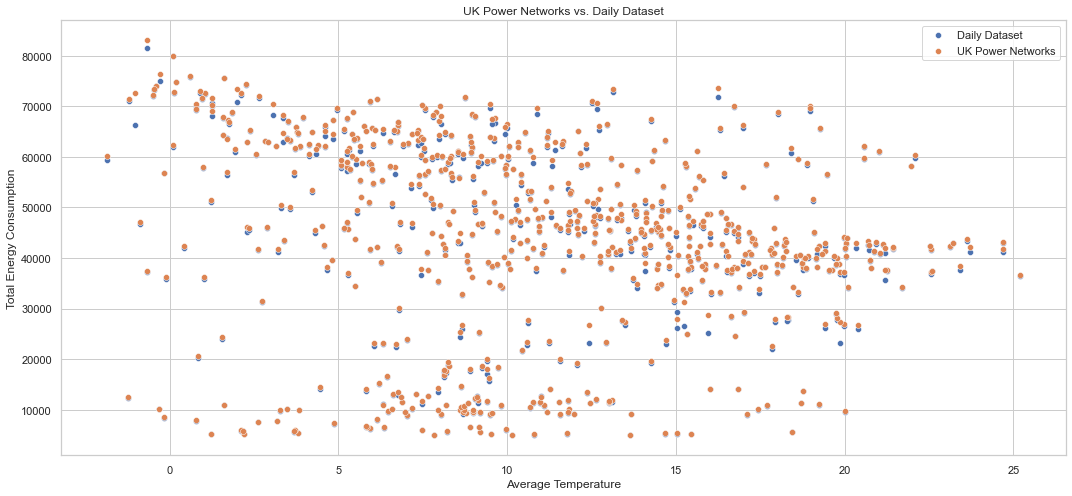

In [147]:
%%time
# Display both data sources on the same plot to identify if there is variation in the data
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,8))
sns.scatterplot(x="Temp_Avg", y="EC_Sum",
                data=df_DailyDataset_ByDate_WithWeather)
sns.scatterplot(x="Temp_Avg", y="EC",
                data=df_UKPowerNetworks_ByDate_WithWeather).set_title('UK Power Networks vs. Daily Dataset')
plt.xlabel('Average Temperature')
plt.ylabel('Total Energy Consumption')
plt.legend(['Daily Dataset','UK Power Networks'])
plt.grid(True)

Wall time: 111 ms


Text(0.5, 1.0, 'Daily Dataset')

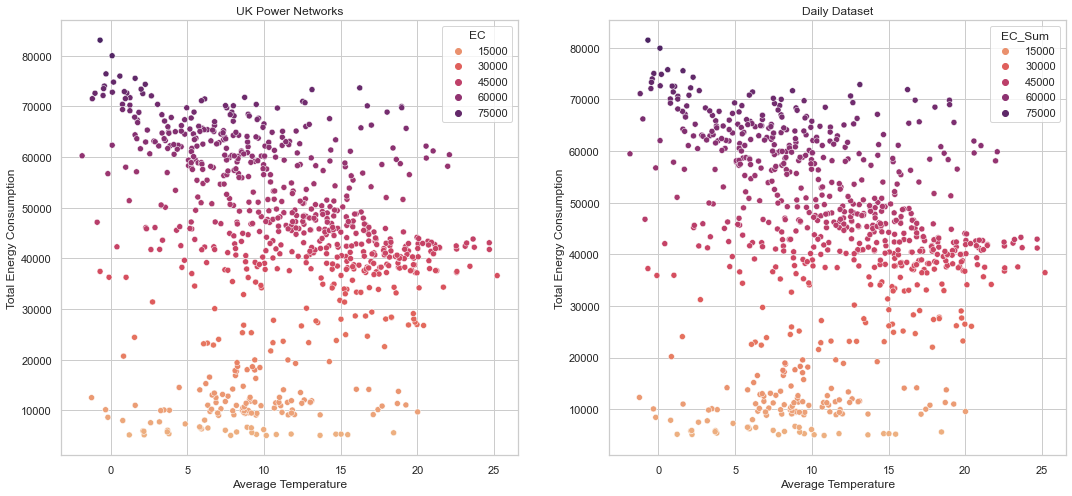

In [146]:
%%time
# Display both data sources on separate (side-by-side) plots to see if they both resemble the same trend
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,8))
for ax in axes:
    ax.set(xlabel='Average Temperature', ylabel='Total Energy Consumption')
    ax.grid(True)
sns.scatterplot(x="Temp_Avg", y="EC", hue="EC", palette="flare",
                data=df_UKPowerNetworks_ByDate_WithWeather, ax=axes[0]).set_title('UK Power Networks')
sns.scatterplot(x="Temp_Avg", y="EC_Sum", hue="EC_Sum", palette="flare",
                data=df_DailyDataset_ByDate_WithWeather, ax=axes[1]).set_title('Daily Dataset')

---
---
# Task 2: Overlay and Explore impact of UK Holiday on energy consumption 

### Steps:
1. Overlay UK Holiday over day-level data
2. To obtain energy consumption, we will use the UK Power Networks data source and sum all energy consumptions for that given date - this will tell us how much energy was consumed on that date

In [203]:
df_UKPowerNetworks_ByDate_WithWeather[['DateOnly', 'EC']]
df_UKPowerNetworks_ByDate_WithWeather[['DateOnly', 'Temp_Avg']]
df_UKPowerNetworks_ByDate_WithWeather['DateOnly']

0      2012-01-01
1      2012-01-02
2      2012-01-03
3      2012-01-04
4      2012-01-05
          ...    
726    2013-12-27
727    2013-12-28
728    2013-12-29
729    2013-12-30
730    2013-12-31
Name: DateOnly, Length: 731, dtype: object

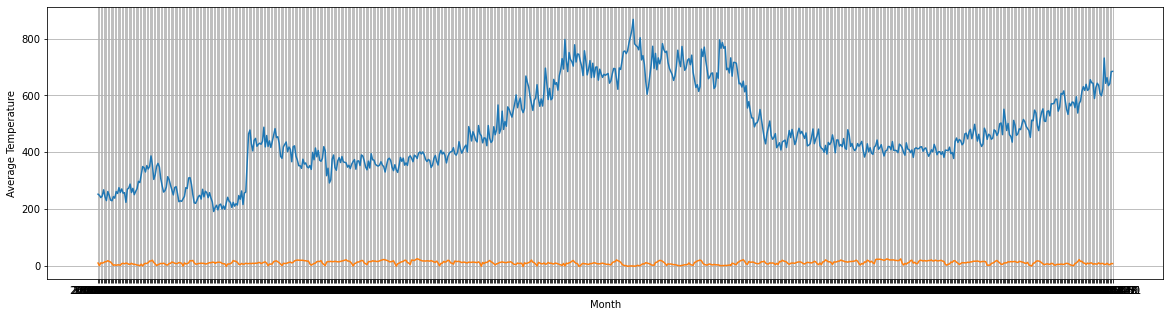

In [205]:
#df_UKPowerNetworks_ByDate_WithWeather.plot(x='DateOnly', y='EC', figsize=(20,5), grid=True, legend = True)

plt.figure(figsize=(20,5)) 
plt.plot(df_UKPowerNetworks_ByDate_WithWeather['DateOnly'], df_UKPowerNetworks_ByDate_WithWeather['EC'])
plt.plot(df_UKPowerNetworks_ByDate_WithWeather['DateOnly'], df_UKPowerNetworks_ByDate_WithWeather['Temp_Avg'])
plt.xlabel('Month')
plt.ylabel('Average Temperature')
#plt.legend(dict(list(df_Weather_GroupedByYear)))
plt.grid(True)




In [76]:
%%time
# Group By (Household ID and Date Only)
df_UKPowerNetworks_ByHouse_ByDate = df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).agg({'EC': 'sum'})
# Reset index to push multi-key as columns
df_UKPowerNetworks_ByHouse_ByDate.reset_index()
# Re-assign as Dask Dataframe
# df_UKPowerNetworks_ByHouse_ByDate = ddf.from_pandas(df_UKPowerNetworks_ByHouse_ByDate, npartitions=4)
    

df_UKPowerNetworks_ByHouse_ByDate.to_csv('dataset/testTask1Output/v_dask2.csv', single_file=True)
df_UKPowerNetworks_ByHouse_ByDate.count().compute()

Wall time: 39.2 s


EC    35318
dtype: int64

In [42]:
%%time

df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv',
                                              names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                              header=0)
#Load_UKPowerNetworksData_UsingDask('dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_*.csv')

Wall time: 22 ms


# TESTING

In [286]:
#df_UKPowerNetworks_ByDate[df_UKPowerNetworks_ByDate.EC['count'] != 48].EC.count().compute()

In [6]:
def Prepare_UKPowerNetworksData_UsingDask(InputFilePath, OuputFilePath):
    # Load Data
    df_UKPowerNetworks_FullSet = ddf.read_csv(FilePath,
                                              names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                              header=0)

    # Filter out invalid households
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet.HouseID.isin(df_Households['ID'])]
    
    # Convert 'Date' to DateTime data type
    df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

    # Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
    ## Declare midnight
    midnight = datetime.time(0,0)
    ## Extract midnight records
    df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight].compute()
    ## Remove midnight records from dask dataframe
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
    ## Shift midnight to -1 minute
    df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
    ## Re-merge updated records with dask dataframe
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

    # Filter out excluded dates (Study Time Frame)
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                            &
                                                            (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

    # Convert EC readings to numeric (otherwise NaN)
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

    # Filter out invalid energy consumption readings
    df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

    # Create Date Only attribute to allow for group-by function
    df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)
    # Group By (Household ID and Date Only)
    df_UKPowerNetworks_ByHouse_ByDate = pd.DataFrame(df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).EC.sum().compute())
    # Reset index to push multi-key as columns
    df_UKPowerNetworks_ByHouse_ByDate.reset_index(inplace=True)
    # Re-assign as Dask Dataframe
    df_UKPowerNetworks_ByHouse_ByDate = ddf.from_pandas(df_UKPowerNetworks_ByHouse_ByDate, npartitions=4)
    

    df_UKPowerNetworks_ByHouse_ByDate.to_csv(OuputFilePath, index=False, single_file=True)
    df_UKPowerNetworks_ByHouse_ByDate.count().compute()

In [43]:
df_UKPowerNetworks_FullSet.count().compute()

HouseID    1000000
tariff     1000000
Date       1000000
EC         1000000
AC_Code    1000000
AC_Name    1000000
dtype: int64

In [41]:
df_UKPowerNetworks_FullSet.count().compute()

HouseID    960931
tariff     960931
Date       960931
EC         960931
AC_Code    960931
AC_Name    960931
dtype: int64

In [39]:
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet.HouseID.isin(df_Households['ID'])]

In [ ]:
directory = r'C:\Users\admin'
for entry in os.scandir(directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        print(entry.path)

In [65]:
df_UKPowerNetworks_FullSet[(df_UKPowerNetworks_FullSet.HouseID == 'MAC005565') & (df_UKPowerNetworks_FullSet.DateOnly == '2012-12-19') ].EC.isna().compute()

9860    True
Name: EC, dtype: bool

In [ ]:
df_UKPowerNetworks_FullSet.loc

In [62]:
df_test1_3[(df_test1_3.HouseID == 'MAC005565') & (df_test1_3.DateOnly == '2012-12-19') ].compute()

,HouseID,DateOnly,EC
36544,MAC005565,2012-12-19,0.0


In [191]:
#df_UKPowerNetworks_FullSet.head()
df_UKPowerNetworks_ByHouse_ByDate = df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).EC.sum().compute()

In [223]:
df_temp = pd.DataFrame(df_UKPowerNetworks_ByHouse_ByDate)
df_temp.reset_index(inplace=True)
df_temp = ddf.from_pandas(df_temp, npartitions=4)
df_temp.head()

,HouseID,DateOnly,EC
0,MAC000002,2012-10-12,7.361
1,MAC000002,2012-10-13,11.086
2,MAC000002,2012-10-14,13.153
3,MAC000002,2012-10-15,10.302
4,MAC000002,2012-10-16,9.689


In [141]:
mergedDate = ddf.merge(left=df_UKHolidays, right=df_Weather[['DateOnly', 'Temp_Avg']], left_on='DateOnly', right_on='DateOnly')
mergedDate

,Date,Name,DateOnly,Temp_Avg
0,2012-02-01,New Year?s Day (substitute day),2012-02-01,6.130
1,2012-04-06,Spring bank holiday (substitute day),2012-04-06,11.270
2,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday),2012-05-06,15.325
3,2012-06-04,Good Friday,2012-06-04,8.670
4,2012-07-05,Early May bank holiday,2012-07-05,13.835
5,2012-08-27,Summer bank holiday,2012-08-27,18.735
6,2012-09-04,Easter Monday,2012-09-04,9.420
7,2012-12-25,Christmas Day,2012-12-25,7.800
8,2012-12-26,Boxing Day,2012-12-26,7.505
9,2013-01-01,New Year?s Day,2013-01-01,5.400


In [180]:
df_UKPowerNetworks_FullSet

,HouseID,tariff,Date,EC,AC_Code,AC_Name
npartitions=5,,,,,,
,object,object,datetime64[ns],int64,object,object
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [181]:
#dask.dataframe.to_numeric(df_UKPowerNetworks_FullSet.EC, errors='coerce').compute()

df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

In [139]:
df_UKPowerNetworks_FullSet.EC.isnull().count().compute()

1754104

In [94]:
print (df_UKPowerNetworks_FullSet.EC.count())

#df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(df_UKPowerNetworks_FullSet.EC.apply(tryParseNumeric)) == True]
df_UKPowerNetworks_FullSet.tail()

#print (df_UKPowerNetworks_FullSet.EC.count().compute())

1754044


,HouseID,tariff,Date,EC,AC_Code,AC_Name
932843,MAC000034,Std,2013-06-23 23:59:00,0.062,ACORN-E,Affluent
932891,MAC000034,Std,2013-06-24 23:59:00,0.071,ACORN-E,Affluent
932892,MAC000034,Std,2013-06-24 23:59:00,0.071,ACORN-E,Affluent
932940,MAC000034,Std,2013-06-25 23:59:00,0.205,ACORN-E,Affluent
932988,MAC000034,Std,2013-06-26 23:59:00,0.133,ACORN-E,Affluent


In [84]:
#df_UKPowerNetworks_FullSet.where(tryParseNumeric(df_UKPowerNetworks_FullSet.EC) == True)

df_UKPowerNetworks_FullSet[(df_UKPowerNetworks_FullSet.EC.apply(tryParseNumeric, meta=('EC', bool))) == False].compute()

,HouseID,tariff,Date,EC,AC_Code,AC_Name
3240,MAC000002,Std,2012-12-19 12:37:27,Null,ACORN-A,Affluent
38710,MAC000003,Std,2012-12-19 12:37:26,Null,ACORN-P,Adversity
70386,MAC000004,Std,2012-12-19 12:32:40,Null,ACORN-E,Affluent
106846,MAC000006,Std,2012-12-19 12:37:26,Null,ACORN-Q,Adversity
131897,MAC000007,Std,2012-12-19 12:37:27,Null,ACORN-H,Comfortable
163719,MAC000008,Std,2012-12-19 12:37:27,Null,ACORN-H,Comfortable
183152,MAC000009,Std,2012-12-19 12:37:27,Null,ACORN-L,Adversity
208192,MAC000010,Std,2012-12-19 12:37:27,Null,ACORN-H,Comfortable
231899,MAC000011,Std,2012-12-19 12:37:28,Null,ACORN-N,Adversity
256569,MAC000012,Std,2012-12-19 12:37:28,Null,ACORN-E,Affluent


In [71]:
df_UKPowerNetworks_FullSet.head()

,HouseID,tariff,Date,EC,AC_Code,AC_Name
0,MAC000002,Std,2012-10-12 00:30:00,0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00,0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00,0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00,0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00,0,ACORN-A,Affluent


In [339]:
mrdirecttest = ddf.read_csv('dataset/testTask1Output/v_directmr.csv')
mrdirecttest.count().compute()

['MAC000002', '2012-10-12']    73085
7.361000000000001              73085
dtype: int64

In [337]:
df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight].EC.count().compute()

1932474

In [55]:
%%time
# Define variables for shorter py command lines
fYS = StudyTimeFrame_StartYear
fYE = StudyTimeFrame_EndYear

# Py Command Line Arguments
PyArgs = f'--fYS {fYS} --fYE {fYE}'

Wall time: 0 ns


In [122]:
testmrjob = pd.read_csv('./dataset/UK_Power_Networks/1simpletest.csv')
#testmrjob

In [111]:
dftest = pd.read_csv('testoutput.csv', names=["Key", "Start"])
dftest['Key'][0]

dftest['householdID'] = dftest['Key'].str.split("([^']+\w)", expand=True)[1]
dftest['date'] = dftest['Key'].str.split("([^']+\w)", expand=True)[3]
dftest['Key'].str.split("([^']+\w)", expand=True)

dftest
#(?P<date>[\s\S]+) - (?P<message>[\s\S]+)'

,Key,Start,householdID,date
0,"['MAC000002', '2012-10-12']",7.361,MAC000002,2012-10-12
1,"['MAC000002', '2012-10-13']",11.086,MAC000002,2012-10-13
2,"['MAC000002', '2012-10-14']",13.153,MAC000002,2012-10-14
3,"['MAC000002', '2012-10-15']",10.302,MAC000002,2012-10-15
4,"['MAC000002', '2012-10-16']",9.689,MAC000002,2012-10-16
...,...,...,...,...
18847,"['MAC000036', '2012-11-04']",2.432,MAC000036,2012-11-04
18848,"['MAC000036', '2012-11-05']",2.337,MAC000036,2012-11-05
18849,"['MAC000036', '2012-11-06']",2.354,MAC000036,2012-11-06
18850,"['MAC000036', '2012-11-07']",2.595,MAC000036,2012-11-07


In [54]:
%%time
#!python MRSumEnergyConsumptionByDate.py $PyArgs "./dataset/UK_Power_Networks/1simpletest.csv"
!python MR_SumEC_ByHousehold_ByDate.py $PyArgs "./dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv"

["MAC000002", "2012-10-12"]	7.361000000000001
["MAC000002", "2012-10-13"]	11.086000000000002
["MAC000002", "2012-10-14"]	13.153
["MAC000002", "2012-10-15"]	10.302000000000001
["MAC000002", "2012-10-16"]	9.688999999999998
["MAC000002", "2012-10-17"]	11.016000000000002
["MAC000002", "2012-10-18"]	10.628
["MAC000002", "2012-10-19"]	8.666
["MAC000002", "2012-10-20"]	17.567999899999997
["MAC000002", "2012-10-21"]	24.5310001
["MAC000002", "2012-10-22"]	18.674
["MAC000002", "2012-10-23"]	10.451999999999998
["MAC000002", "2012-10-24"]	15.636000099999999
["MAC000002", "2012-10-25"]	13.095999999999998
["MAC000002", "2012-10-26"]	15.354
["MAC000002", "2012-10-27"]	16.82
["MAC000002", "2012-10-28"]	19.622999899999996
["MAC000002", "2012-10-29"]	12.959000000000003
["MAC000002", "2012-10-30"]	13.832000000000006
["MAC000002", "2012-10-31"]	17.552000099999997
["MAC000002", "2012-11-01"]	12.270999999999997
["MAC000002", "2012-11-02"]	14.576
["MAC000002", "2012-11-03"]	14.306999999999999
["MAC000002", "

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MR_SumEC_ByHousehold_ByDate.ARamadan.20201215.171116.508338
Running step 1 of 1...
job output is in C:\Users\ARamadan\AppData\Local\Temp\MR_SumEC_ByHousehold_ByDate.ARamadan.20201215.171116.508338\output
Streaming final output from C:\Users\ARamadan\AppData\Local\Temp\MR_SumEC_ByHousehold_ByDate.ARamadan.20201215.171116.508338\output...
Removing temp directory C:\Users\ARamadan\AppData\Local\Temp\MR_SumEC_ByHousehold_ByDate.ARamadan.20201215.171116.508338...


["MAC000002", "2013-01-02"]	13.2429999
["MAC000002", "2013-01-03"]	10.135
["MAC000002", "2013-01-04"]	9.795000000000003
["MAC000002", "2013-01-05"]	11.232999999999999
["MAC000002", "2013-01-06"]	10.277000000000001
["MAC000002", "2013-01-07"]	9.427000000000001
["MAC000002", "2013-01-08"]	11.6770001
["MAC000002", "2013-01-09"]	15.158999999999999
["MAC000002", "2013-01-10"]	10.826999999999998
["MAC000002", "2013-01-11"]	10.9849999
["MAC000002", "2013-01-12"]	10.581999900000003
["MAC000002", "2013-01-13"]	10.309
["MAC000002", "2013-01-14"]	12.300999999999998
["MAC000002", "2013-01-15"]	9.846000000000002
["MAC000002", "2013-01-16"]	14.378000100000003
["MAC000002", "2013-01-17"]	9.840000000000005
["MAC000002", "2013-01-18"]	16.904000100000005
["MAC000002", "2013-01-19"]	15.816000000000003
["MAC000002", "2013-01-20"]	11.693000000000001
["MAC000002", "2013-01-21"]	12.4540001
["MAC000002", "2013-01-22"]	10.870000100000002
["MAC000002", "2013-01-23"]	11.038
["MAC000002", "2013-01-24"]	12.142
["M

["MAC000003", "2012-04-11"]	13.998000000000005
["MAC000003", "2012-04-12"]	19.136000100000004
["MAC000003", "2012-04-13"]	15.1770001
["MAC000003", "2012-04-14"]	15.187999999999999
["MAC000003", "2012-04-15"]	14.525000100000003
["MAC000003", "2012-04-16"]	18.616
["MAC000003", "2012-04-17"]	14.814000099999998
["MAC000003", "2012-04-18"]	17.429000000000002
["MAC000003", "2012-04-19"]	14.973999999999997
["MAC000003", "2012-04-20"]	15.2949999
["MAC000003", "2012-04-21"]	12.660999999999996
["MAC000003", "2012-04-22"]	14.238000199999993
["MAC000003", "2012-04-23"]	15.5940001
["MAC000003", "2012-04-24"]	15.374000000000008
["MAC000003", "2012-04-25"]	14.170000200000004
["MAC000003", "2012-04-26"]	13.764000000000001
["MAC000003", "2012-04-27"]	14.7619999
["MAC000003", "2012-04-28"]	14.184000000000005
["MAC000003", "2012-04-29"]	16.532000000000004
["MAC000003", "2012-04-30"]	11.454
["MAC000003", "2012-05-01"]	11.168
["MAC000003", "2012-05-02"]	11.709999900000001
["MAC000003", "2012-05-03"]	14.355

["MAC000004", "2013-05-17"]	1.612
["MAC000004", "2013-05-18"]	1.7970000000000002
["MAC000004", "2013-05-19"]	1.467
["MAC000004", "2013-05-20"]	1.706
["MAC000004", "2013-05-21"]	1.6159999999999999
["MAC000004", "2013-05-22"]	1.534
["MAC000004", "2013-05-23"]	1.6290000000000002
["MAC000004", "2013-05-24"]	1.7199999999999998
["MAC000004", "2013-05-25"]	1.6880000000000002
["MAC000004", "2013-05-26"]	1.768
["MAC000004", "2013-05-27"]	1.446
["MAC000004", "2013-05-28"]	1.6199999999999997
["MAC000004", "2013-05-29"]	1.5720000000000003
["MAC000004", "2013-05-30"]	1.715
["MAC000004", "2013-05-31"]	1.593
["MAC000004", "2013-06-01"]	1.549
["MAC000004", "2013-06-02"]	1.6629999999999998
["MAC000004", "2013-06-03"]	1.6580000000000001
["MAC000004", "2013-06-04"]	1.557
["MAC000004", "2013-06-05"]	1.415
["MAC000004", "2013-06-06"]	1.6300000000000001
["MAC000004", "2013-06-07"]	1.7009999999999998
["MAC000004", "2013-06-08"]	1.3809999999999998
["MAC000004", "2013-06-09"]	1.6329999999999998
["MAC000004", "

["MAC000008", "2012-06-28"]	13.664999999999997
["MAC000008", "2012-06-29"]	16.758999999999993
["MAC000008", "2012-06-30"]	9.025
["MAC000008", "2012-07-01"]	18.137
["MAC000008", "2012-07-02"]	12.396
["MAC000008", "2012-07-03"]	14.349
["MAC000008", "2012-07-04"]	12.760000000000002
["MAC000008", "2012-07-05"]	11.776000000000002
["MAC000008", "2012-07-06"]	14.658000000000001
["MAC000008", "2012-07-07"]	14.811000000000003
["MAC000008", "2012-07-08"]	18.076000000000004
["MAC000008", "2012-07-09"]	19.307000000000002
["MAC000008", "2012-07-10"]	13.766999999999994
["MAC000008", "2012-07-11"]	12.614000000000003
["MAC000008", "2012-07-12"]	18.768999900000004
["MAC000008", "2012-07-13"]	24.648000099999997
["MAC000008", "2012-07-14"]	15.857999999999997
["MAC000008", "2012-07-15"]	15.989
["MAC000008", "2012-07-16"]	14.9060001
["MAC000008", "2012-07-17"]	15.9380001
["MAC000008", "2012-07-18"]	14.839000000000002
["MAC000008", "2012-07-19"]	16.436
["MAC000008", "2012-07-20"]	19.988000099999997
["MAC000

["MAC000010", "2012-12-26"]	37.9330005
["MAC000010", "2012-12-27"]	35.79699989999999
["MAC000010", "2012-12-28"]	33.047
["MAC000010", "2012-12-29"]	38.88899990000001
["MAC000010", "2012-12-30"]	22.005000099999993
["MAC000010", "2012-12-31"]	34.989999899999994
["MAC000010", "2013-01-01"]	32.5580001
["MAC000010", "2013-01-02"]	32.083000000000006
["MAC000010", "2013-01-03"]	30.781999900000002
["MAC000010", "2013-01-04"]	34.20799999999999
["MAC000010", "2013-01-05"]	29.4189998
["MAC000010", "2013-01-06"]	35.6869996
["MAC000010", "2013-01-07"]	37.098000000000006
["MAC000010", "2013-01-08"]	37.36
["MAC000010", "2013-01-09"]	32.887999900000004
["MAC000010", "2013-01-10"]	23.718000000000007
["MAC000010", "2013-01-11"]	30.161
["MAC000010", "2013-01-12"]	26.485
["MAC000010", "2013-01-13"]	31.870999700000002
["MAC000010", "2013-01-14"]	29.141999899999995
["MAC000010", "2013-01-15"]	33.813
["MAC000010", "2013-01-16"]	27.363999899999996
["MAC000010", "2013-01-17"]	24.302999900000003
["MAC000010", "

["MAC000012", "2013-04-12"]	7.406000000000001
["MAC000012", "2013-04-13"]	5.8939999999999975
["MAC000012", "2013-04-14"]	5.223999999999999
["MAC000012", "2013-04-15"]	2.8060000000000005
["MAC000012", "2013-04-16"]	1.2950000000000006
["MAC000012", "2013-04-17"]	1.243
["MAC000012", "2013-04-18"]	1.3250000000000002
["MAC000012", "2013-04-19"]	1.2230000000000003
["MAC000012", "2013-04-20"]	1.1940000000000004
["MAC000012", "2013-04-21"]	1.2720000000000002
["MAC000012", "2013-04-22"]	1.2850000000000004
["MAC000012", "2013-04-23"]	1.2520000000000002
["MAC000012", "2013-04-24"]	1.3589999999999998
["MAC000012", "2013-04-25"]	1.4430000000000005
["MAC000012", "2013-04-26"]	1.4620000000000002
["MAC000012", "2013-04-27"]	1.2570000000000003
["MAC000012", "2013-04-28"]	1.318
["MAC000012", "2013-04-29"]	1.1910000000000003
["MAC000012", "2013-04-30"]	1.2370000000000003
["MAC000012", "2013-05-01"]	1.246
["MAC000012", "2013-05-02"]	1.3100000000000005
["MAC000012", "2013-05-03"]	1.3070000000000002
["MAC00

["MAC000018", "2012-06-09"]	6.321000000000001
["MAC000018", "2012-06-10"]	5.894
["MAC000018", "2012-06-11"]	9.100999999999999
["MAC000018", "2012-06-12"]	8.309000000000001
["MAC000018", "2012-06-13"]	13.336
["MAC000018", "2012-06-14"]	10.206999999999999
["MAC000018", "2012-06-15"]	10.052999999999999
["MAC000018", "2012-06-16"]	16.235
["MAC000018", "2012-06-17"]	11.502999999999998
["MAC000018", "2012-06-18"]	13.286000000000001
["MAC000018", "2012-06-19"]	11.007
["MAC000018", "2012-06-20"]	11.01
["MAC000018", "2012-06-21"]	15.679999899999999
["MAC000018", "2012-06-22"]	10.710999999999999
["MAC000018", "2012-06-23"]	12.499
["MAC000018", "2012-06-24"]	12.080000000000004
["MAC000018", "2012-06-25"]	10.752000000000002
["MAC000018", "2012-06-26"]	14.034000100000002
["MAC000018", "2012-06-27"]	14.997000000000002
["MAC000018", "2012-06-28"]	11.361000000000002
["MAC000018", "2012-06-29"]	8.613
["MAC000018", "2012-06-30"]	6.791999999999998
["MAC000018", "2012-07-01"]	6.166000000000001
["MAC000018

["MAC000019", "2013-06-20"]	3.940000000000001
["MAC000019", "2013-06-21"]	3.8940000000000006
["MAC000019", "2013-06-22"]	5.489
["MAC000019", "2013-06-23"]	7.656000000000001
["MAC000019", "2013-06-24"]	7.216000000000001
["MAC000019", "2013-06-25"]	5.715
["MAC000019", "2013-06-26"]	5.974
["MAC000019", "2013-06-27"]	7.558000000000001
["MAC000019", "2013-06-28"]	7.640999999999999
["MAC000019", "2013-06-29"]	6.626000000000001
["MAC000019", "2013-06-30"]	6.407
["MAC000019", "2013-07-01"]	3.894000000000001
["MAC000019", "2013-07-02"]	3.930999999999999
["MAC000019", "2013-07-03"]	3.863
["MAC000019", "2013-07-04"]	3.858000000000002
["MAC000019", "2013-07-05"]	4.090000000000002
["MAC000019", "2013-07-06"]	5.207
["MAC000019", "2013-07-07"]	8.582
["MAC000019", "2013-07-08"]	7.592000000000001
["MAC000019", "2013-07-09"]	5.168000000000001
["MAC000019", "2013-07-10"]	4.194000000000002
["MAC000019", "2013-07-11"]	4.3500000000000005
["MAC000019", "2013-07-12"]	4.056000000000001
["MAC000019", "2013-07-1

["MAC000021", "2012-04-12"]	22.894000000000005
["MAC000021", "2012-04-13"]	25.435
["MAC000021", "2012-04-14"]	17.122
["MAC000021", "2012-04-15"]	17.973999999999997
["MAC000021", "2012-04-16"]	23.815999999999995
["MAC000021", "2012-04-17"]	30.0700001
["MAC000021", "2012-04-18"]	33.5949999
["MAC000021", "2012-04-19"]	33.948
["MAC000021", "2012-04-20"]	23.779999999999994
["MAC000021", "2012-04-21"]	18.28
["MAC000021", "2012-04-22"]	20.638000000000005
["MAC000021", "2012-04-23"]	25.401
["MAC000021", "2012-04-24"]	31.793000099999997
["MAC000021", "2012-04-25"]	27.403999900000006
["MAC000021", "2012-04-26"]	26.956000000000007
["MAC000021", "2012-04-27"]	23.378999999999998
["MAC000021", "2012-04-28"]	23.795
["MAC000021", "2012-04-29"]	24.504
["MAC000021", "2012-04-30"]	26.055
["MAC000021", "2012-05-01"]	31.60900000000001
["MAC000021", "2012-05-02"]	22.078000000000003
["MAC000021", "2012-05-03"]	26.173000000000005
["MAC000021", "2012-05-04"]	23.350999999999996
["MAC000021", "2012-05-05"]	23.82

["MAC000022", "2013-07-17"]	5.754
["MAC000022", "2013-07-18"]	6.284000000000001
["MAC000022", "2013-07-19"]	5.078
["MAC000022", "2013-07-20"]	4.668
["MAC000022", "2013-07-21"]	4.822
["MAC000022", "2013-07-22"]	4.4590000000000005
["MAC000022", "2013-07-23"]	5.832000000000001
["MAC000022", "2013-07-24"]	6.387000000000001
["MAC000022", "2013-07-25"]	5.393
["MAC000022", "2013-07-26"]	6.208
["MAC000022", "2013-07-27"]	4.23
["MAC000022", "2013-07-28"]	6.127
["MAC000022", "2013-07-29"]	5.342999999999998
["MAC000022", "2013-07-30"]	5.531000000000001
["MAC000022", "2013-07-31"]	5.739000000000001
["MAC000022", "2013-08-01"]	5.128
["MAC000022", "2013-08-02"]	5.747000000000002
["MAC000022", "2013-08-03"]	6.011000000000002
["MAC000022", "2013-08-04"]	6.145
["MAC000022", "2013-08-05"]	5.0680000000000005
["MAC000022", "2013-08-06"]	6.497999999999999
["MAC000022", "2013-08-07"]	5.420000000000002
["MAC000022", "2013-08-08"]	5.215000000000001
["MAC000022", "2013-08-09"]	7.711000000000001
["MAC000022", "

["MAC000024", "2013-02-13"]	35.425999900000015
["MAC000024", "2013-02-14"]	48.7540001
["MAC000024", "2013-02-15"]	45.48700009999998
["MAC000024", "2013-02-16"]	34.567000199999995
["MAC000024", "2013-02-17"]	34.54000009999999
["MAC000024", "2013-02-18"]	37.41800000000001
["MAC000024", "2013-02-19"]	40.7539999
["MAC000024", "2013-02-20"]	28.29499949999999
["MAC000024", "2013-02-21"]	36.7520001
["MAC000024", "2013-02-22"]	38.3530001
["MAC000024", "2013-02-23"]	30.080000100000003
["MAC000024", "2013-02-24"]	27.8129998
["MAC000024", "2013-02-25"]	37.3239999
["MAC000024", "2013-02-26"]	33.734999900000005
["MAC000024", "2013-02-27"]	36.324
["MAC000024", "2013-02-28"]	38.9929999
["MAC000024", "2013-03-01"]	32.91599980000001
["MAC000024", "2013-03-02"]	33.5179998
["MAC000024", "2013-03-03"]	34.87999989999999
["MAC000024", "2013-03-04"]	40.75800019999999
["MAC000024", "2013-03-05"]	26.156999800000015
["MAC000024", "2013-03-06"]	24.8429997
["MAC000024", "2013-03-07"]	26.6479999
["MAC000024", "201

["MAC000026", "2012-11-14"]	19.97799999999999
["MAC000026", "2012-11-15"]	12.805999999999997
["MAC000026", "2012-11-16"]	19.01
["MAC000026", "2012-11-17"]	19.738
["MAC000026", "2012-11-18"]	18.325
["MAC000026", "2012-11-19"]	22.534000000000002
["MAC000026", "2012-11-20"]	16.965
["MAC000026", "2012-11-21"]	16.754
["MAC000026", "2012-11-22"]	19.753
["MAC000026", "2012-11-23"]	18.61
["MAC000026", "2012-11-24"]	13.967000000000002
["MAC000026", "2012-11-25"]	17.219
["MAC000026", "2012-11-26"]	14.357000000000003
["MAC000026", "2012-11-27"]	18.902999999999995
["MAC000026", "2012-11-28"]	20.600999999999996
["MAC000026", "2012-11-29"]	20.616999999999997
["MAC000026", "2012-11-30"]	18.224000000000004
["MAC000026", "2012-12-01"]	17.282999999999998
["MAC000026", "2012-12-02"]	15.909
["MAC000026", "2012-12-03"]	21.944999999999993
["MAC000026", "2012-12-04"]	18.6350001
["MAC000026", "2012-12-05"]	19.975
["MAC000026", "2012-12-06"]	21.668000100000004
["MAC000026", "2012-12-07"]	25.029999999999998
["M

["MAC000028", "2012-09-17"]	5.9940000000000015
["MAC000028", "2012-09-18"]	6.634
["MAC000028", "2012-09-19"]	5.908000000000001
["MAC000028", "2012-09-20"]	5.073000000000001
["MAC000028", "2012-09-21"]	6.239000000000002
["MAC000028", "2012-09-22"]	5.592
["MAC000028", "2012-09-23"]	5.787000000000001
["MAC000028", "2012-09-24"]	6.449
["MAC000028", "2012-09-25"]	5.2620000000000005
["MAC000028", "2012-09-26"]	6.8530000000000015
["MAC000028", "2012-09-27"]	5.917
["MAC000028", "2012-09-28"]	5.878999999999999
["MAC000028", "2012-09-29"]	5.7669999999999995
["MAC000028", "2012-09-30"]	5.436999999999999
["MAC000028", "2012-10-01"]	6.738999999999999
["MAC000028", "2012-10-02"]	6.071000000000001
["MAC000028", "2012-10-03"]	6.398
["MAC000028", "2012-10-04"]	5.990999999999999
["MAC000028", "2012-10-05"]	5.995
["MAC000028", "2012-10-06"]	5.336000000000001
["MAC000028", "2012-10-07"]	5.274000000000001
["MAC000028", "2012-10-08"]	7.782
["MAC000028", "2012-10-09"]	6.324
["MAC000028", "2012-10-10"]	6.8359

["MAC000030", "2012-09-18"]	6.6380000000000035
["MAC000030", "2012-09-19"]	15.195
["MAC000030", "2012-09-20"]	9.487
["MAC000030", "2012-09-21"]	11.659999899999997
["MAC000030", "2012-09-22"]	12.3109999
["MAC000030", "2012-09-23"]	21.1059999
["MAC000030", "2012-09-24"]	5.940999999999999
["MAC000030", "2012-09-25"]	5.846000000000001
["MAC000030", "2012-09-26"]	15.972000000000001
["MAC000030", "2012-09-27"]	15.5769999
["MAC000030", "2012-09-28"]	12.235000000000001
["MAC000030", "2012-09-29"]	12.591000000000001
["MAC000030", "2012-09-30"]	21.865999900000002
["MAC000030", "2012-10-01"]	18.8109999
["MAC000030", "2012-10-02"]	6.246000000000001
["MAC000030", "2012-10-03"]	6.162999999999999
["MAC000030", "2012-10-04"]	9.178000000000004
["MAC000030", "2012-10-05"]	5.229000000000002
["MAC000030", "2012-10-06"]	6.9860000000000015
["MAC000030", "2012-10-07"]	4.3020000000000005
["MAC000030", "2012-10-08"]	5.987999999999999
["MAC000030", "2012-10-09"]	7.435
["MAC000030", "2012-10-10"]	6.536
["MAC0000

["MAC000033", "2013-09-13"]	5.982
["MAC000033", "2013-09-14"]	5.3439999999999985
["MAC000033", "2013-09-15"]	7.882999999999999
["MAC000033", "2013-09-16"]	7.318000000000001
["MAC000033", "2013-09-17"]	6.453999999999999
["MAC000033", "2013-09-18"]	8.383000000000001
["MAC000033", "2013-09-19"]	6.940000000000001
["MAC000033", "2013-09-20"]	6.056999999999998
["MAC000033", "2013-09-21"]	7.419
["MAC000033", "2013-09-22"]	6.792000000000001
["MAC000033", "2013-09-23"]	8.934000000000001
["MAC000033", "2013-09-24"]	7.805
["MAC000033", "2013-09-25"]	8.691000000000003
["MAC000033", "2013-09-26"]	6.989
["MAC000033", "2013-09-27"]	6.114999999999998
["MAC000033", "2013-09-28"]	7.340000000000001
["MAC000033", "2013-09-29"]	7.497
["MAC000033", "2013-09-30"]	8.120999999999999
["MAC000033", "2013-10-01"]	5.747000000000001
["MAC000033", "2013-10-02"]	8.431
["MAC000033", "2013-10-03"]	6.840999999999999
["MAC000033", "2013-10-04"]	5.793999999999999
["MAC000033", "2013-10-05"]	7.344
["MAC000033", "2013-10-06

["MAC000035", "2013-12-19"]	29.944
["MAC000035", "2013-12-20"]	21.205
["MAC000035", "2013-12-21"]	35.5319998
["MAC000035", "2013-12-22"]	35.415
["MAC000035", "2013-12-23"]	40.81600019999998
["MAC000035", "2013-12-24"]	30.073999999999995
["MAC000035", "2013-12-25"]	43.3460001
["MAC000035", "2013-12-26"]	32.68899999999999
["MAC000035", "2013-12-27"]	34.253
["MAC000035", "2013-12-28"]	35.38099989999999
["MAC000035", "2013-12-29"]	32.7909997
["MAC000035", "2013-12-30"]	40.18200010000001
["MAC000035", "2013-12-31"]	34.25400009999999
["MAC000036", "2012-01-01"]	2.654
["MAC000036", "2012-01-02"]	2.744
["MAC000036", "2012-01-03"]	2.626000000000001
["MAC000036", "2012-01-04"]	2.5680000000000005
["MAC000036", "2012-01-05"]	2.322
["MAC000036", "2012-01-06"]	2.82
["MAC000036", "2012-01-07"]	2.7960000000000007
["MAC000036", "2012-01-08"]	2.528
["MAC000036", "2012-01-09"]	2.286
["MAC000036", "2012-01-10"]	2.224
["MAC000036", "2012-01-11"]	2.6909999999999994
["MAC000036", "2012-01-12"]	2.719000000000

In [48]:
%%time
import datetime
testmrjob = pd.read_csv('./dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv', nrows=50)
#datetime.datetime.strptime(testmrjob['DateTime'][0])

Wall time: 8 ms


In [51]:
%%time
t1 = pd.to_datetime(testmrjob['DateTime'][46])
print(t1.date())
print(t1.time())

if (t1.time() == datetime.time(0,0)):
    print(True)
    t1 = t1 - datetime.timedelta(minutes = 1)
    print ((t1 - datetime.timedelta(minutes = 1)).date())

print (StudyTimeFrame_StartYear)
print (StudyTimeFrame_EndYear)
print( StudyTimeFrame_StartYear <= t1.date().year <= StudyTimeFrame_EndYear)
print(t1.date())
print(t1.time())
        

2012-10-13
00:00:00
True
2012-10-12
2012
2013
True
2012-10-12
23:59:00
Wall time: 995 µs


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.160954.161299
Running step 1 of 1...

Error while reading from C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.160954.161299\step\000\combiner\00000\input:

Traceback (most recent call last):
  File "MRSumEnergyConsumptionByDate.py", line 104, in <module>
    main(sys.argv[1:])
  File "MRSumEnergyConsumptionByDate.py", line 98, in main
    MR_SumEnergyConsumption_ByDate.run()
  File "C:\Users\ARamadan\.conda\envs\BDSA603\lib\site-packages\mrjob\job.py", line 616, in run
    cls().execute()
  File "C:\Users\ARamadan\.conda\envs\BDSA603\lib\site-packages\mrjob\job.py", line 687, in execute
    self.run_job()
  File "C:\Users\ARamadan\.conda\envs\BDSA603\lib\site-packages\mrjob\job.py", line 636, in run_job
    runner.run()
  File "C:\Users\ARamadan\.conda\

In [62]:
%%time
datetime.datetime.strptime(testmrjob['DateTime'][35], '%Y-%m-%d %H:%M:%S.%f')

ValueError: unconverted data remains: 0

In [108]:
%%time
from MRSumEnergyConsumptionByDate import MR_SumEnergyConsumption_ByDate

Wall time: 0 ns


In [34]:
df_Households.to_csv('dataset_clean/df_Households.csv', index=False)

In [35]:
%%time
!python MRSumEnergyConsumptionByDate.py --fHouseholdsCSV "dataset_clean/df_Households.csv" "./dataset/UK_Power_Networks/1simpletest.csv" 

reached hereWall time: 1.33 s
"2020-12-15"	1.032

"Invalid"	0
"dataset_clean/df_Households.csv"	36
null	72

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.140215.423030
Running step 1 of 1...
job output is in C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.140215.423030\output
Streaming final output from C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.140215.423030\output...
Removing temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201215.140215.423030...


In [109]:
%%time
# with combiner
!python MRSumEnergyConsumptionByDate.py "./dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv"

"2011-12-06"	2.9469999999999996
"2011-12-07"	143.1599998
"2011-12-08"	248.37400010000002
"2011-12-09"	216.327
"2011-12-10"	246.16799980000002
"2011-12-11"	277.64900050000006
"2011-12-12"	266.0419997999999
"2011-12-13"	230.62899959999996
"2011-12-14"	268.98400050000004
"2011-12-15"	277.5710007
"2011-12-16"	262.44599969999996
"2011-12-17"	246.2689998
"2011-12-18"	285.8519997
"2011-12-19"	271.313
"2011-12-20"	281.9519995
"2011-12-21"	266.69700009999997
"2011-12-22"	220.93599960000006
"2011-12-23"	224.91400029999994
"2011-12-24"	225.99599990000002
"2011-12-25"	225.71799979999997
"2011-12-26"	209.4029996
"2011-12-27"	214.37299990000002
"2011-12-28"	251.51200060000014
"2011-12-29"	249.6269995
"2011-12-30"	278.6369999
"2011-12-31"	280.4200004
"2012-01-01"	275.1750002
"2012-01-02"	269.64800030000004Wall time: 1min 39s
"2012-01-03"	267.71900030000006


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082458.575829
Running step 1 of 1...
job output is in C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082458.575829\output
Streaming final output from C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082458.575829\output...
Removing temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082458.575829...



"2012-01-04"	270.5319996
"2012-01-05"	292.92299950000006
"2012-01-06"	258.89500000000004
"2012-01-07"	257.7240006
"2012-01-08"	283.8729998000001
"2012-01-09"	271.96300030000003
"2012-01-10"	254.6949994
"2012-01-11"	250.2020003
"2012-01-12"	263.6129997999999
"2012-01-13"	256.2130003000001
"2012-01-14"	275.13300019999997
"2012-01-15"	274.4840006999999
"2012-01-16"	294.22799999999995
"2012-01-17"	275.16000030000004
"2012-01-18"	291.4149993000001
"2012-01-19"	278.43399980000004
"2012-01-20"	266.9169995
"2012-01-21"	244.5549996
"2012-01-22"	283.2439992999999
"2012-01-23"	293.3799999
"2012-01-24"	304.2549998
"2012-01-25"	276.73999940000004
"2012-01-26"	293.702
"2012-01-27"	262.7159995
"2012-01-28"	279.7929991000001
"2012-01-29"	286.4949999
"2012-01-30"	312.25500009999996
"2012-01-31"	308.68800000000005
"2012-02-01"	340.4499999000001
"2012-02-02"	374.07699979999995
"2012-02-03"	359.57200050000006
"2012-02-04"	345.62499990000003
"2012-02-05"	379.3100001000002
"2012-02-06"	357.1620008
"2012-02

In [97]:
%%time
# without combiner
!python MRSumEnergyConsumptionByDate.py "./dataset/UK_Power_Networks/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv"

"2011-12-06"	2.9469999999999996
"2011-12-07"	143.15999980000012
"2011-12-08"	248.3740000999999
"2011-12-09"	216.3269999999998
"2011-12-10"	246.16799979999982
"2011-12-11"	277.64900050000006
"2011-12-12"	266.04199979999987
"2011-12-13"	230.6289995999998
"2011-12-14"	268.9840004999998
"2011-12-15"	277.5710007000001
"2011-12-16"	262.4459997
"2011-12-17"	246.26899980000002
"2011-12-18"	285.8519997
"2011-12-19"	271.3129999999998
"2011-12-20"	281.9519995000002
"2011-12-21"	266.69700010000025
"2011-12-22"	220.93599959999997
"2011-12-23"	224.91400030000042
"2011-12-24"	225.99599989999993
"2011-12-25"	225.71799980000006
"2011-12-26"	209.4029996
"2011-12-27"	214.37299989999977
"2011-12-28"	251.5120005999999
"2011-12-29"	249.62699949999973
"2011-12-30"	278.63699990000003
"2011-12-31"	280.42000040000005
"2012-01-01"	275.1750001999998
"2012-01-02"	269.6480002999999
"2012-01-03"	267.71900030000006
"2012-01-04"	270.5319996000003
"2012-01-05"	292.9229995
"2012-01-06"	258.895
"2012-01-07"	257.724000599

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.081526.304779
Running step 1 of 1...
job output is in C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.081526.304779\output
Streaming final output from C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.081526.304779\output...
Removing temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.081526.304779...



"2012-04-09"	226.04399990000002
"2012-04-10"	220.05699950000005
"2012-04-11"	256.71500009999994
"2012-04-12"	247.27999999999963
"2012-04-13"	268.8280000999997
"2012-04-14"	223.09899999999985
"2012-04-15"	275.85899990000024
"2012-04-16"	270.44900040000005
"2012-04-17"	273.41400010000024
"2012-04-18"	262.48399969999974
"2012-04-19"	252.82499959999976
"2012-04-20"	222.8479994
"2012-04-21"	190.16099989999998
"2012-04-22"	202.1440001999999
"2012-04-23"	234.6820001000001
"2012-04-24"	216.67500009999978
"2012-04-25"	227.24599979999985
"2012-04-26"	230.2970000999998
"2012-04-27"	243.4419999000001
"2012-04-28"	237.05400039999984
"2012-04-29"	272.16799970000034
"2012-04-30"	230.79500040000025
"2012-05-01"	247.58700040000028
"2012-05-02"	232.72600030000004
"2012-05-03"	236.49099999999996
"2012-05-04"	220.73799990000023
"2012-05-05"	232.51000020000006
"2012-05-06"	267.5110002
"2012-05-07"	266.3199998999996
"2012-05-08"	245.53999970000015
"2012-05-09"	244.7659993999997
"2012-05-10"	230.20599990000

In [110]:
%%time
# without combiner
!python MRSumEnergyConsumptionByDate.py "./dataset/UK_Power_Networks/1simpletest.csv"

"2020-12-14"	1.032
"Invalid"	0
Wall time: 911 ms


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082759.203705
Running step 1 of 1...
job output is in C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082759.203705\output
Streaming final output from C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082759.203705\output...
Removing temp directory C:\Users\ARamadan\AppData\Local\Temp\MRSumEnergyConsumptionByDate.ARamadan.20201214.082759.203705...


In [113]:
pd.to_datetime(datetime.datetime.now()).date()

datetime.date(2020, 12, 14)